### Python imports

In [1]:
import xarray as xr
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep
from functools import partial
import time
import numcodecs
import zarr
import dask
import io
import boto3
from dask.distributed import as_completed
import s3fs
import dask.array as da

### Inputs

In [2]:
def read_dataset_inmemory(s3_path: str) -> xr.Dataset:
    """Read a NetCDF as an XArray using in-memory data"""
    try:
        with io.BytesIO() as inmemoryfile:
            # Use boto to download a file to memory
            # session = boto3.Session(profile_name='nonproduction-admin')
            s3 = boto3.client('s3')
            bucket, key = s3_path.replace("s3://", "").split("/", 1)
            s3.download_fileobj(bucket, key, inmemoryfile)
            inmemoryfile.seek(0)
            return xr.open_dataset(inmemoryfile)
    except ValueError as e:
        print(f"Failed to open the file with error: {e}")
        return None

### Argo Processor

**Source notebook**
https://medium.com/@nicolasmortimer/argo-floats-zarr-and-pangeo-d74fc6d4ce35

*Written by Nicolas Mortimer*

In [3]:
data_types ={'CONFIG_MISSION_NUMBER':'float32','CYCLE_NUMBER':'float32','DATA_CENTRE':'|U2','DATA_MODE':'|U1',
             'DATA_STATE_INDICATOR':'|U4','DC_REFERENCE':'|U32','DIRECTION':'|U1','FIRMWARE_VERSION':'|U32',
             'FLOAT_SERIAL_NO':'|U32','JULD':'float32','JULD_LOCATION':'float32','JULD_QC':'|U1','LATITUDE':'float32',
             'LONGITUDE':'float32','PI_NAME':'|U64','PLATFORM_NUMBER':'|U8','PLATFORM_TYPE':'|U32','POSITIONING_SYSTEM':'|U8',
             'POSITION_QC':'|U1','PRES':'float32','PRES_ADJUSTED':'float32','PRES_ADJUSTED_ERROR':'float32',
             'PRES_ADJUSTED_QC':'|U1','PRES_QC':'|U1','PROFILE_PRES_QC':'|U1','PROFILE_PSAL_QC':'|U1','PROFILE_TEMP_QC':'|U1',
             'PROJECT_NAME':'|U64','PSAL':'float32','PSAL_ADJUSTED':'float32','PSAL_ADJUSTED_ERROR':'float32',
             'PSAL_ADJUSTED_QC':'|U1','PSAL_QC':'|U1','TEMP':'float32','TEMP_ADJUSTED':'float32','TEMP_ADJUSTED_ERROR':'float32',
             'TEMP_ADJUSTED_QC':'|U1','TEMP_QC':'|U1','VERTICAL_SAMPLING_SCHEME':'|U256','WMO_INST_TYPE':'|U4'}

data_levels =['PRES','PRES_ADJUSTED','PRES_ADJUSTED_ERROR','PRES_ADJUSTED_QC','PRES_QC','PSAL','PSAL_ADJUSTED',
              'PSAL_ADJUSTED_ERROR','PSAL_ADJUSTED_QC','PSAL_QC','TEMP','TEMP_ADJUSTED','TEMP_ADJUSTED_ERROR',
              'TEMP_ADJUSTED_QC','TEMP_QC']

def process_mf(dsinput,levels,data_types=data_types,data_levels=data_levels):
    ds = xr.Dataset()
    dims =('N_PROF','N_LEVELS')
    # The number of profiles is indicated by the N_PROF dimension
    # The number of pressure levels is indicated by the N_LEVELS dimension
    pading =xr.DataArray(np.ones((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))) *np.nan,dims=dims)
    pad_qc = xr.DataArray(np.chararray((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))),dims=dims)
    pad_qc[:] = b' '
    for varname in data_types.keys():
        if varname in dsinput.data_vars:
            da = dsinput[varname]
            if 'N_LEVELS' in da.dims:   
                if varname in dsinput.data_vars:
                    if varname.endswith('QC'):
                        da = xr.concat([dsinput[varname],pad_qc],dim='N_LEVELS').astype(data_types[varname])
                    else:
                        da = xr.concat([dsinput[varname],pading],dim='N_LEVELS').astype(data_types[varname])
            else:
                da = dsinput[varname].astype(data_types[varname])
        else:
            if varname in data_levels:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones((len(dsinput.N_PROF),levels), dtype='float32')*np.nan , name=varname, dims=['N_PROF','N_LEVELS'])
                else:
                    p=np.chararray((len(dsinput.N_PROF),levels))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF','N_LEVELS'])
            else:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones(len(dsinput.N_PROF), dtype="float32")*np.nan , name=varname, dims=['N_PROF'])
                else:
                    p=np.chararray((len(dsinput.N_PROF)))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF'])
        if not ('HISTORY' in varname) and ('N_CALIB' not in da.dims) and ('N_PARAM' not in da.dims) and  ('N_PROF' in da.dims):
                ds[varname]= da
    return ds.chunk({'N_LEVELS':levels})

In [4]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

### Generate dataset and export to Zarr

Paths and store declaration

In [5]:
%%time
# aws_profile = 'nonproduction-admin'
s3 = s3fs.S3FileSystem(anon=False)
source_path = 's3://imos-data/IMOS/Argo/dac/csiro/1901119/profiles/*.nc'
glob_result = s3.glob(source_path)
output_name = 'argo-test'
store_path = f's3://vietnguyen-dask/testing/{output_name}.zarr' #change this to unique prefix while testing
store = s3fs.S3Map(root=f'{store_path}', s3=s3, check=False)
input_paths = []
input_paths.extend(['s3://' + path for path in glob_result])
all_chunked_paths = list(chunks(input_paths, 500))
start_from = 0 # index of all_chunked_paths

CPU times: user 127 ms, sys: 12.3 ms, total: 139 ms
Wall time: 1.51 s


In [6]:
read_dataset_inmemory(input_paths[0])

<xarray.Dataset>
Dimensions:                       (N_PROF: 1, N_PARAM: 3, N_LEVELS: 70,
                                   N_CALIB: 1, N_HISTORY: 9)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/64)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    HISTORY_ACTION                (N_HISTORY, N_PROF) object ...
    HISTORY_PARAMETER             (N_HISTORY, N_PROF) object ...
    HISTORY_START_PRES            (N_HISTORY, N_PROF) float32 ...
    HISTORY_STOP_PRES             (N_HISTORY, N_PROF) float32 ...
    HISTORY_PREVIOUS_VALUE        (N_HISTORY, N_PROF) float32 ...
    HISTORY_QCTEST                (N_HISTORY, N_PROF) object ...
Attributes:
    title:                Argo float vertical profile
    institution:          CSIRO
    source:               Argo float
    history:              2013-07-27T12:59:35Z creation;2014-08-15T15:22:01Z ...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  3.1
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile

In [7]:
input_paths = input_paths[:8]
all_chunked_paths = list(chunks(input_paths, 2))
print(len(all_chunked_paths))

4


### Using Dask

#### Fargate cluster

In [8]:
# from dask_cloudprovider.aws import FargateCluster
# from dask.distributed import Client

# arn_role = ''
# dask_image = 'ghcr.io/vietnguyengit/vietnguyen-dask:main'

# cluster = FargateCluster(image=dask_image, 
#                          scheduler_timeout="60 minutes", 
#                          task_role_arn=arn_role,
#                          scheduler_cpu=4096, scheduler_mem=30720)
# cluster.scale(5)

# client = Client(cluster)
# display(client)

#### Local cluster

#### Dask extension local cluster

In [40]:
import dask
from dask.distributed import Client, LocalCluster

dask_user = 'vietnguyen'
dask_address = 'localhost'
dask_port = '0'

with dask.config.set({'temporary_directory': f'/home/{dask_user}/dask/'}):
    # set up cluster and workers
    cluster = LocalCluster(n_workers=4, memory_limit='8GB', processes=True, 
                           threads_per_worker=4, dashboard_address=f':{dask_port}', ip=dask_address)
    client = Client(address=cluster.scheduler_address)

print(f'http://{dask_address}'+':{port}/status'.format(port=client.scheduler_info().get('services').get('dashboard')))

http://localhost:36273/status


**with @dask.delayed**

In [10]:
# @dask.delayed
# def process_float(s3_uri):
#     preproc = partial(process_mf,levels=3000)
#     file = read_dataset_inmemory(s3_uri)
#     data = preproc(file)
#     return data

# start_time = time.time()
# print('************** Processing Zarr **************')
# for i in tqdm(range(len(all_chunked_paths))):
#     overwrite = True if i == 0 else False
#     sleep_yet = True if i > 0 and i % 5 == 0 else False #tell dask to pause after processing every 5000 files
#     if i >= start_from:
#         datasets = []
#         for path in all_chunked_paths[i]:
#             datasets.append(process_float(path))
#         zarrs = dask.compute(*datasets) 
#         zarrs_remote = client.scatter(zarrs)
#         ds_future = [client.submit(xr.concat, zarrs_remote, 
#                                    dim='N_PROF', coords='minimal',
#                                    compat='override',combine_attrs='override', 
#                                    fill_value='')]
#         for done in as_completed(ds_future):
#             ds = done.result()
#             for var in ds.data_vars:
#                 ds[var].encoding = {} 
#             if overwrite:
#                 # to_zarr() lazily
#                 z = ds.to_zarr(store, mode='w', consolidated=True, compute=False)
#             else:
#                 z = ds.to_zarr(store, mode='a', append_dim='N_PROF', consolidated=True, compute=False)
#             sleep(10) if sleep_yet else sleep(5) # take some break before writing to S3
#             # z_persisted = client.persist(z)
#             z.compute()
#         else:
#             pass

# print('*********************************************')
# print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))
# print('*********************************************')

************** Processing Zarr **************


100%|█████████████████████████████████████████████| 4/4 [03:49<00:00, 57.26s/it]

*********************************************
---------- Total: 229.05 seconds ----------
*********************************************


**Dask future**

In [36]:
# def process_float(s3_uri):
#     preproc = partial(process_mf,levels=3000)
#     file = read_dataset_inmemory(s3_uri)
#     data = preproc(file)
#     return data
# start_time = time.time()
# print('************** Processing Zarr **************')
# for i in tqdm(range(len(all_chunked_paths))):
#     overwrite = True if i == 0 else False
#     sleep_yet = True if i > 0 and i % 5 == 0 else False #tell dask to pause after processing every 5000 files
#     if i >= start_from:
#         futures = []
#         for path in all_chunked_paths[i]:
#             futures.append(client.submit(process_float, path, retries=10))
#         zarrs = client.gather(futures) # result return to local from the cluster
#         ds = xr.concat(zarrs, dim='N_PROF', coords='minimal',compat='override',combine_attrs='override', fill_value='')
#         # chunked = ds.chunk(chunks=1000)
#         for var in ds.data_vars:
#             ds[var].encoding = {}
#         if overwrite:
#             z = ds.to_zarr(store, mode='w', consolidated=True, compute=False) # return delayed obj
#         else:
#             z = ds.to_zarr(store, mode='a', append_dim='N_PROF', consolidated=True, compute=False)
#         sleep(10) if sleep_yet else sleep(5) # take some break before writing to S3
#         # z_persisted = client.persist(z)
#         z.compute()
#     else:
#         pass   
# print('*********************************************')
# print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))
# print('*********************************************')

************** Processing Zarr **************


100%|█████████████████████████████████████████████| 4/4 [04:34<00:00, 68.72s/it]

*********************************************
---------- Total: 274.88 seconds ----------
*********************************************


In [39]:
# cluster.close()
# client.close()

### Open Zarr and Visualisation

Use Dask if possible to run this section for performance improvement

In [41]:
%%time
data = xr.open_zarr(store_path)
data

CPU times: user 94 ms, sys: 6.02 ms, total: 100 ms
Wall time: 265 ms


<xarray.Dataset>
Dimensions:                   (N_PROF: 8, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(1,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>

In [42]:
import matplotlib.pyplot as plt
from datetime import datetime

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

In [43]:
# Profile Plot
nprof = 0 #Specify a profile to plot

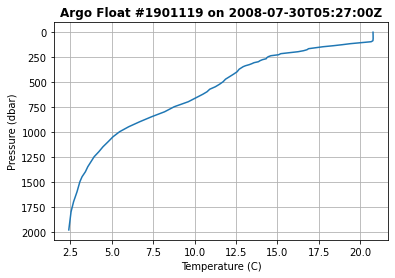

CPU times: user 1.73 s, sys: 1.4 s, total: 3.13 s
Wall time: 8.07 s


In [44]:
%%time
plt.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.gca().invert_yaxis() #Flip the y-axis
plt.show()

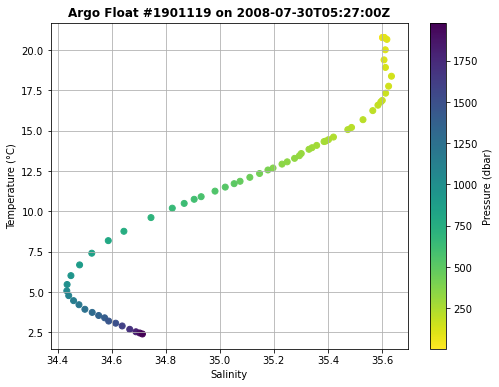

CPU times: user 600 ms, sys: 215 ms, total: 815 ms
Wall time: 1.02 s


In [45]:
%%time
plt.figure(figsize=(8,6))
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.show()

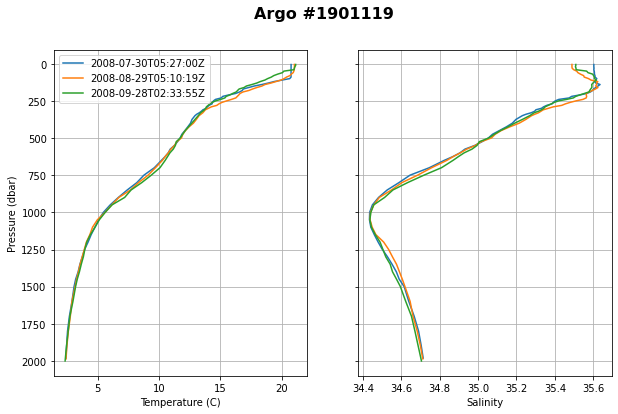

CPU times: user 928 ms, sys: 228 ms, total: 1.16 s
Wall time: 1.74 s


In [46]:
%%time
# Profile Plot
# Subplot example
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10,6))
nprof = 0 # First profile
ax1.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof], label=np_dt64_to_dt(data.JULD[nprof].values))
ax2.plot(data.PSAL_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])
nprof_mid = nprof + 3
ax1.plot(data.TEMP_ADJUSTED[nprof_mid], data.PRES_ADJUSTED[nprof_mid], label=np_dt64_to_dt(data.JULD[nprof_mid].values))
ax2.plot(data.PSAL_ADJUSTED[nprof_mid], data.PRES_ADJUSTED[nprof_mid])
nprof_last = nprof_mid + 3 # Last profile
ax1.plot(data.TEMP_ADJUSTED[nprof_last], data.PRES_ADJUSTED[nprof_last], label=np_dt64_to_dt(data.JULD[nprof_last].values))
ax2.plot(data.PSAL_ADJUSTED[nprof_last], data.PRES_ADJUSTED[nprof_last])
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
ax2.set_xlabel('Salinity')
ax1.invert_yaxis()
ax1.legend()
# Add some gridlines
ax1.grid()
ax2.grid()
# Add a super title
fig.suptitle('Argo #%d' % data.PLATFORM_NUMBER[nprof].values, fontweight='bold', fontsize=16)
plt.show()

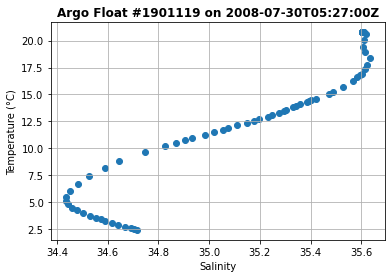

CPU times: user 335 ms, sys: 208 ms, total: 543 ms
Wall time: 698 ms


In [47]:
%%time
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof])
plt.xlabel('Salinity')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold')
plt.show()

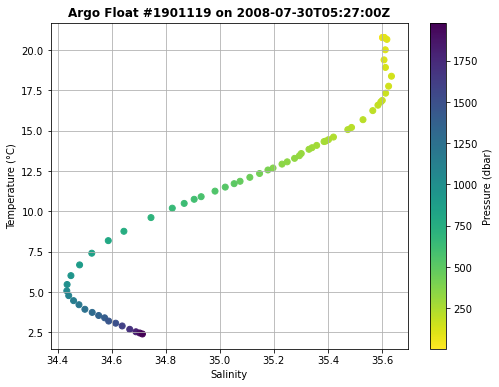

CPU times: user 597 ms, sys: 246 ms, total: 842 ms
Wall time: 978 ms


In [48]:
%%time
plt.figure(figsize=(8,6))
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold')
plt.show()